# Identifiying Orchestrated Social Media Post through sentiment analysis 

In [1]:
import pandas as pd 
import numpy as np
import re
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

In [2]:
# Importing datasets and preprocessing
df = pd.read_csv('/workspaces/codespaces-jupyter/Skool/FYPTest.csv')
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,Unnamed: 0,Tweets,Date,Likes,RTs,Orchestrate
0,0,@renato_mariotti What misinformation? \nApple ...,2022-11-29 09:33:46+00:00,0,0,0.0
1,1,Ridley #CCP Mandy #世界杯 Landon #利物浦 Humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0
2,2,@rachaelvenables @LBC They must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0
3,3,@lukedepulford Still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0
4,4,2024 Bentley Continental GT V8 Convertible Ful...,2022-11-29 09:33:06+00:00,0,0,0.0


In [3]:
# Drop columns that are not needed and lowercase all the data
df.drop(columns=df.columns[0], axis=1, inplace=True)
df = df.apply(lambda x: x.astype(str).str.lower())

In [4]:
df['Tweets'].iloc[15]

'@wholemarsblog of course apple are helping the ccp squash the ongoing unrest, apple will do what ever &amp; to whoever… https://t.co/nx8t8ja8pn'

## Using Twitter-Roberta for sentimen analysis

In [5]:
# twitter-roberta-base-sentiment model works better with minimalistic amount of manipulation to the data
# just let the model know that there is username http links
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = "@user" if t.startswith("@") and len(t) > 1 else t
        t = "http" if t.startswith("http") else t
        new_text.append(t)
    return " ".join(new_text)


# apply the preprocessing functions to the content
df["roberta_content"] = df["Tweets"].apply(preprocess)
df.head()

,Tweets,Date,Likes,RTs,Orchestrate,roberta_content
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...


In [6]:
# model, tokenizer and so on are located in the following repo
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

# a function that takes text and model to calculate probability of each sentiment
def sentiment_analyzer(text, model):

    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = np.round(softmax(scores), 2)
    scores_dict = {"neg": scores[0], "neu": scores[1], "pos": scores[2]}
    return scores_dict

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
%%time
# apply the roberta function
df["probabilities"] = df["roberta_content"].apply(
    sentiment_analyzer, model=roberta_model
)
df.head()

CPU times: user 10min 22s, sys: 5.69 s, total: 10min 28s
Wall time: 5min 17s


,Tweets,Date,Likes,RTs,Orchestrate,roberta_content,probabilities
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...,"{'neg': 0.36, 'neu': 0.62, 'pos': 0.01}"
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,"{'neg': 0.01, 'neu': 0.92, 'pos': 0.06}"
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...,"{'neg': 0.86, 'neu': 0.13, 'pos': 0.01}"
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...,"{'neg': 0.52, 'neu': 0.46, 'pos': 0.02}"
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...,"{'neg': 0.01, 'neu': 0.91, 'pos': 0.08}"


In [8]:
# let's convert each probaility into separate column
probabilities = df["probabilities"].apply(pd.Series)
df = df.join(probabilities)
df = df.drop("probabilities", axis=1)
df.head()

,Tweets,Date,Likes,RTs,Orchestrate,roberta_content,neg,neu,pos
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...,0.36,0.62,0.01
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,0.01,0.92,0.06
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...,0.86,0.13,0.01
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...,0.52,0.46,0.02
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...,0.01,0.91,0.08


In [9]:
# first multiplying each probability to its weights (-1=> negative, 0=>neutral and +1=>positive)
# then sum the values and pass through Tanh function to scale values from -1 up to +1
# finally we can assign labels for each text, depending on the polarity, e.g. -1.0 until -0.25 negavite
polarity_weights = torch.tensor([-1, 0, 1])
probs = torch.tensor(df[["neg", "neu", "pos"]].values)
polarity = polarity_weights * probs
polarity = polarity.sum(dim=-1)
polarity_scaled = nn.Tanh()(polarity)
df["roberta_polarity"] = polarity_scaled.numpy()
df["roberta_sentiment"] = pd.cut(
    df["roberta_polarity"],
    bins=[-1.0, -0.25, 0.25, 1.0],
    labels=["Negative", "Neutral", "Positive"],
)
df = df.drop(["neu", "neg", "pos"], axis=1)
df.head()

,Tweets,Date,Likes,RTs,Orchestrate,roberta_content,roberta_polarity,roberta_sentiment
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...,-0.336376,Negative
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,0.049958,Neutral
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...,-0.691069,Negative
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...,-0.462117,Negative
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...,0.069886,Neutral


<Axes: xlabel='roberta_sentiment', ylabel='count'>

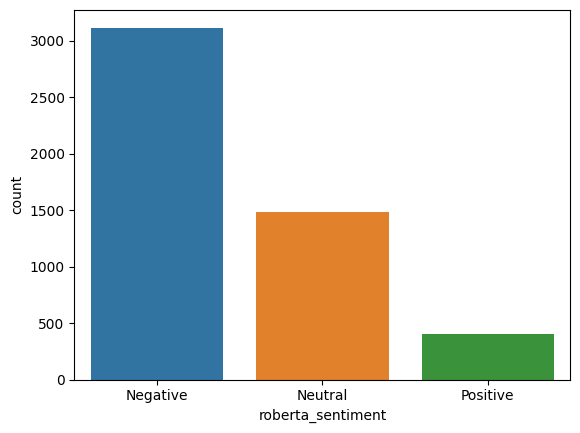

In [10]:
sns.countplot(x='roberta_sentiment', data=df)

## Further Text Cleaning for tokenization

In [11]:
#Extracting URLs to a new column
df['urls'] = df['Tweets'].str.extract(r'(https?://\S+)')[0].tolist()

#Extracting tagged users to a new column
pattern = r'@(\w+)'
df['tagged_users'] = None
for index, row in df.iterrows():
    tweet_text = row['Tweets']
    tagged_users = re.findall(pattern, tweet_text)
    df.at[index, 'tagged_users'] = tagged_users


#Removing URLs and Unicodes from tweets
df['clean_tweets'] = df['Tweets'].replace(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+", "", regex=True)

#Removing emojis from tweets
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               "\ufe0f"  # dingbats
                               "\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Applying function to remoive emojis from clean tweets 
df['clean_tweets'] = df['clean_tweets'].apply(lambda x: remove_emoji(x))
df.head()

,Tweets,Date,Likes,RTs,Orchestrate,roberta_content,roberta_polarity,roberta_sentiment,urls,tagged_users,clean_tweets
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...,-0.336376,Negative,https://t.co/q3x1vuckdw,[renato_mariotti],mariotti what misinformation apple is cooperat...
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,0.049958,Neutral,https://t.co/pigd9g8nas,[],ridley ccp mandy landon humble
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...,-0.691069,Negative,NaN,"[rachaelvenables, lbc]",they must be being funded by the ccp to dama...
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...,-0.462117,Negative,https://t.co/dca2xqx7tf,[lukedepulford],still waiting for him to shut down the confuc...
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...,0.069886,Neutral,https://t.co/xnsdiedx4c,[],2024 bentley continental gt v8 convertible ful...


In [12]:
# View tagged_user column ensure right data is extracted
df['tagged_users'].head()

0         [renato_mariotti]
1                        []
2    [rachaelvenables, lbc]
3           [lukedepulford]
4                        []
Name: tagged_users, dtype: object

In [13]:
df['clean_tweets'].iloc[0]

'mariotti what misinformation apple is cooperating with the ccp btw to prevent the protesters from commun '

In [14]:
# Creating new column for only removing puncutaions and URLs
df['clean_tweets2'] = df['Tweets'].replace(r'[^\w\s]', '', regex=True)
df['clean_tweets2'] = df['clean_tweets2'].replace(r'\n', '', regex=True)
df['clean_tweets2'] = df['clean_tweets2'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df['clean_tweets2'].iloc[0]

'renato_mariotti what misinformation apple is cooperating with the ccp btw to prevent the protesters from commun '

%pip install nltk

In [15]:
# Downloading stopwords and removing them from tweets
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
df['clean_tweets_stopword'] = df['clean_tweets2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tweets,Date,Likes,RTs,Orchestrate,roberta_content,roberta_polarity,roberta_sentiment,urls,tagged_users,clean_tweets,clean_tweets2,clean_tweets_stopword
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...,-0.336376,Negative,https://t.co/q3x1vuckdw,[renato_mariotti],mariotti what misinformation apple is cooperat...,renato_mariotti what misinformation apple is c...,renato_mariotti misinformation apple cooperati...
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,0.049958,Neutral,https://t.co/pigd9g8nas,[],ridley ccp mandy landon humble,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...,-0.691069,Negative,NaN,"[rachaelvenables, lbc]",they must be being funded by the ccp to dama...,rachaelvenables lbc they must be being funded ...,rachaelvenables lbc must funded ccp damage eco...
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...,-0.462117,Negative,https://t.co/dca2xqx7tf,[lukedepulford],still waiting for him to shut down the confuc...,lukedepulford still waiting for him to shut do...,lukedepulford still waiting shut confucius ins...
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...,0.069886,Neutral,https://t.co/xnsdiedx4c,[],2024 bentley continental gt v8 convertible ful...,2024 bentley continental gt v8 convertible ful...,2024 bentley continental gt v8 convertible ful...


In [16]:
# Removing numbers from tweets
df['clean_tweets_stopword'] = df['clean_tweets_stopword'].str.replace('\d+', '')
df['clean_tweets'] = df['clean_tweets'].str.replace('\d+', '')
df['clean_tweets2'] = df['clean_tweets2'].str.replace('\d+', '')
df.head()

,Tweets,Date,Likes,RTs,Orchestrate,roberta_content,roberta_polarity,roberta_sentiment,urls,tagged_users,clean_tweets,clean_tweets2,clean_tweets_stopword
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...,-0.336376,Negative,https://t.co/q3x1vuckdw,[renato_mariotti],mariotti what misinformation apple is cooperat...,renato_mariotti what misinformation apple is c...,renato_mariotti misinformation apple cooperati...
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,0.049958,Neutral,https://t.co/pigd9g8nas,[],ridley ccp mandy landon humble,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...,-0.691069,Negative,NaN,"[rachaelvenables, lbc]",they must be being funded by the ccp to dama...,rachaelvenables lbc they must be being funded ...,rachaelvenables lbc must funded ccp damage eco...
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...,-0.462117,Negative,https://t.co/dca2xqx7tf,[lukedepulford],still waiting for him to shut down the confuc...,lukedepulford still waiting for him to shut do...,lukedepulford still waiting shut confucius ins...
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...,0.069886,Neutral,https://t.co/xnsdiedx4c,[],2024 bentley continental gt v8 convertible ful...,2024 bentley continental gt v8 convertible ful...,2024 bentley continental gt v8 convertible ful...


In [17]:
# Lemmatizing tweets
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['clean_tweets_sw_lemma'] = df['clean_tweets_stopword'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Tweets,Date,Likes,RTs,Orchestrate,roberta_content,roberta_polarity,roberta_sentiment,urls,tagged_users,clean_tweets,clean_tweets2,clean_tweets_stopword,clean_tweets_sw_lemma
0,@renato_mariotti what misinformation? \napple ...,2022-11-29 09:33:46+00:00,0,0,0.0,@user what misinformation? \napple is cooperat...,-0.336376,Negative,https://t.co/q3x1vuckdw,[renato_mariotti],mariotti what misinformation apple is cooperat...,renato_mariotti what misinformation apple is c...,renato_mariotti misinformation apple cooperati...,renato_mariotti misinformation apple cooperati...
1,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,2022-11-29 09:33:43+00:00,0,0,1.0,ridley #ccp mandy #世界杯 landon #利物浦 humble #世界杯...,0.049958,Neutral,https://t.co/pigd9g8nas,[],ridley ccp mandy landon humble,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注
2,@rachaelvenables @lbc they must be being funde...,2022-11-29 09:33:32+00:00,0,0,1.0,@user @user they must be being funded by the c...,-0.691069,Negative,NaN,"[rachaelvenables, lbc]",they must be being funded by the ccp to dama...,rachaelvenables lbc they must be being funded ...,rachaelvenables lbc must funded ccp damage eco...,rachaelvenables lbc must funded ccp damage eco...
3,@lukedepulford still waiting for him to shut d...,2022-11-29 09:33:18+00:00,0,0,1.0,@user still waiting for him to shut down the c...,-0.462117,Negative,https://t.co/dca2xqx7tf,[lukedepulford],still waiting for him to shut down the confuc...,lukedepulford still waiting for him to shut do...,lukedepulford still waiting shut confucius ins...,lukedepulford still waiting shut confucius ins...
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,2024 bentley continental gt v8 convertible ful...,0.069886,Neutral,https://t.co/xnsdiedx4c,[],2024 bentley continental gt v8 convertible ful...,2024 bentley continental gt v8 convertible ful...,2024 bentley continental gt v8 convertible ful...,2024 bentley continental gt v8 convertible ful...


In [18]:
df['clean_tweets_sw_lemma'].iloc[0]

'renato_mariotti misinformation apple cooperating ccp btw prevent protester commun'

 ### List of each clean tweets properties
 clean_tweets (Removed twtter tagged user)  <br>
 clean_tweets2 (Remain raw as possible)  <br>
 clean_tweets_sw_lemma (Remove stopword / lemmatized)

In [19]:
print(df['clean_tweets'].iloc[17])
print(df['clean_tweets2'].iloc[17])
print(df['clean_tweets_sw_lemma'].iloc[17])

 apple hates free speech so much they worked with the ccp to disrupt communications of protesters in china 
jdcocchiarella apple hates free speech so much they worked with the ccp to disrupt communications of protesters in china 
jdcocchiarella apple hate free speech much worked ccp disrupt communication protester china


df (Orginal dataframe)  <br>
df_clean_af (Cleaned dataframe)  <br>
df3 (Cleaned dataframe with sentiment analysis)  <br>
df4 (Cleaned dataframe with sentiment analysis and topic modeling)  <br>

In [20]:
# move clean_tweets_sw_lemma to the a new dataframe
df_clean_af = df[['clean_tweets_sw_lemma', 'Date', 'Likes', 'RTs', 'Orchestrate', 'urls', 'tagged_users']].copy()
df_clean_af.rename(columns={'clean_tweets_sw_lemma': 'clean_tweets'}, inplace=True)
df_clean_af['clean_tweets_raw'] = df['clean_tweets_sw_lemma']
df_clean_af.head(10)

,clean_tweets,Date,Likes,RTs,Orchestrate,urls,tagged_users,clean_tweets_raw
0,renato_mariotti misinformation apple cooperati...,2022-11-29 09:33:46+00:00,0,0,0.0,https://t.co/q3x1vuckdw,[renato_mariotti],renato_mariotti misinformation apple cooperati...
1,ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注,2022-11-29 09:33:43+00:00,0,0,1.0,https://t.co/pigd9g8nas,[],ridley ccp mandy 世界杯 landon 利物浦 humble 世界杯投注
2,rachaelvenables lbc must funded ccp damage eco...,2022-11-29 09:33:32+00:00,0,0,1.0,NaN,"[rachaelvenables, lbc]",rachaelvenables lbc must funded ccp damage eco...
3,lukedepulford still waiting shut confucius ins...,2022-11-29 09:33:18+00:00,0,0,1.0,https://t.co/dca2xqx7tf,[lukedepulford],lukedepulford still waiting shut confucius ins...
4,2024 bentley continental gt v8 convertible ful...,2022-11-29 09:33:06+00:00,0,0,0.0,https://t.co/xnsdiedx4c,[],2024 bentley continental gt v8 convertible ful...
5,yet moron national government want align russi...,2022-11-29 09:33:01+00:00,0,0,0.0,https://t.co/rgm6kmzbxb,[],yet moron national government want align russi...
6,snellarthur cant wait afghanistan wreck ccp next,2022-11-29 09:32:56+00:00,0,0,1.0,NaN,[snellarthur],snellarthur cant wait afghanistan wreck ccp next
7,jack dorsey tweet end ccp china zero covid mea...,2022-11-29 09:32:37+00:00,0,0,0.0,https://t.co/x0nznicfbp,[nypost],jack dorsey tweet end ccp china zero covid mea...
8,8yfwlhl3oj8xgzs cosmos04801113 johnpilger ccp ...,2022-11-29 09:32:36+00:00,0,0,0.0,NaN,"[8yfwlhl3oj8xgzs, cosmos04801113, johnpilger]",8yfwlhl3oj8xgzs cosmos04801113 johnpilger ccp ...
9,carlquintanilla onlyyoontv cnbc cnbctechcheck ...,2022-11-29 09:32:33+00:00,0,0,1.0,https://t.co/fpg4piz2d1,"[carlquintanilla, onlyyoontv, cnbc, cnbctechch...",carlquintanilla onlyyoontv cnbc cnbctechcheck ...


### Tokenizing Words

In [21]:
# Tokenizing tweets for every clean tweets
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Tokenize the tweets twice  to ensure that the tweets are tokenized
df_clean_af['clean_tweets'] = df_clean_af['clean_tweets'].apply(lambda x: word_tokenize(str(x)))
df_clean_af['clean_tweets'] = df_clean_af['clean_tweets'].apply(lambda x: word_tokenize(str(x)))
df_clean_af['clean_tweets_raw'] = df_clean_af['clean_tweets_raw'].apply(lambda x: word_tokenize(str(x)))
df_clean_af.head()

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,clean_tweets,Date,Likes,RTs,Orchestrate,urls,tagged_users,clean_tweets_raw
0,"[[, 'renato_mariotti, ', ,, 'misinformation, '...",2022-11-29 09:33:46+00:00,0,0,0.0,https://t.co/q3x1vuckdw,[renato_mariotti],"[renato_mariotti, misinformation, apple, coope..."
1,"[[, 'ridley, ', ,, 'ccp, ', ,, 'mandy, ', ,, '...",2022-11-29 09:33:43+00:00,0,0,1.0,https://t.co/pigd9g8nas,[],"[ridley, ccp, mandy, 世界杯, landon, 利物浦, humble,..."
2,"[[, 'rachaelvenables, ', ,, 'lbc, ', ,, 'must,...",2022-11-29 09:33:32+00:00,0,0,1.0,NaN,"[rachaelvenables, lbc]","[rachaelvenables, lbc, must, funded, ccp, dama..."
3,"[[, 'lukedepulford, ', ,, 'still, ', ,, 'waiti...",2022-11-29 09:33:18+00:00,0,0,1.0,https://t.co/dca2xqx7tf,[lukedepulford],"[lukedepulford, still, waiting, shut, confuciu..."
4,"[[, '2024, ', ,, 'bentley, ', ,, 'continental,...",2022-11-29 09:33:06+00:00,0,0,0.0,https://t.co/xnsdiedx4c,[],"[2024, bentley, continental, gt, v8, convertib..."


In [22]:
df_clean_af['clean_tweets'].iloc[17]

['[',
 "'jdcocchiarella",
 "'",
 ',',
 "'apple",
 "'",
 ',',
 "'hate",
 "'",
 ',',
 "'free",
 "'",
 ',',
 "'speech",
 "'",
 ',',
 "'much",
 "'",
 ',',
 "'worked",
 "'",
 ',',
 "'ccp",
 "'",
 ',',
 "'disrupt",
 "'",
 ',',
 "'communication",
 "'",
 ',',
 "'protester",
 "'",
 ',',
 "'china",
 "'",
 ']']

## Generate a word cloud image for each clean tweets properties 

%pip install wordcloud

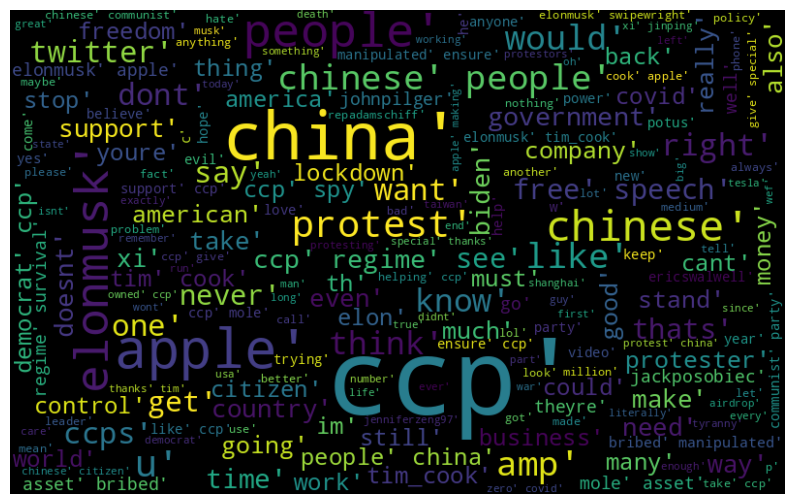

In [23]:
# Generate a wordcloud for all tweets in the clean_tweets
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_words = ' '.join(''.join(text) for text in df_clean_af['clean_tweets'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [24]:
# Convert the list to a string
df_clean_af['clean_tweets_str'] = df_clean_af['clean_tweets'].apply(lambda x: ' '.join(map(str, x)))
df_clean_af.head()

,clean_tweets,Date,Likes,RTs,Orchestrate,urls,tagged_users,clean_tweets_raw,clean_tweets_str
0,"[[, 'renato_mariotti, ', ,, 'misinformation, '...",2022-11-29 09:33:46+00:00,0,0,0.0,https://t.co/q3x1vuckdw,[renato_mariotti],"[renato_mariotti, misinformation, apple, coope...","[ 'renato_mariotti ' , 'misinformation ' , 'ap..."
1,"[[, 'ridley, ', ,, 'ccp, ', ,, 'mandy, ', ,, '...",2022-11-29 09:33:43+00:00,0,0,1.0,https://t.co/pigd9g8nas,[],"[ridley, ccp, mandy, 世界杯, landon, 利物浦, humble,...","[ 'ridley ' , 'ccp ' , 'mandy ' , '世界杯 ' , 'la..."
2,"[[, 'rachaelvenables, ', ,, 'lbc, ', ,, 'must,...",2022-11-29 09:33:32+00:00,0,0,1.0,NaN,"[rachaelvenables, lbc]","[rachaelvenables, lbc, must, funded, ccp, dama...","[ 'rachaelvenables ' , 'lbc ' , 'must ' , 'fun..."
3,"[[, 'lukedepulford, ', ,, 'still, ', ,, 'waiti...",2022-11-29 09:33:18+00:00,0,0,1.0,https://t.co/dca2xqx7tf,[lukedepulford],"[lukedepulford, still, waiting, shut, confuciu...","[ 'lukedepulford ' , 'still ' , 'waiting ' , '..."
4,"[[, '2024, ', ,, 'bentley, ', ,, 'continental,...",2022-11-29 09:33:06+00:00,0,0,0.0,https://t.co/xnsdiedx4c,[],"[2024, bentley, continental, gt, v8, convertib...","[ '2024 ' , 'bentley ' , 'continental ' , 'gt ..."


<Axes: xlabel='Orchestrate', ylabel='count'>

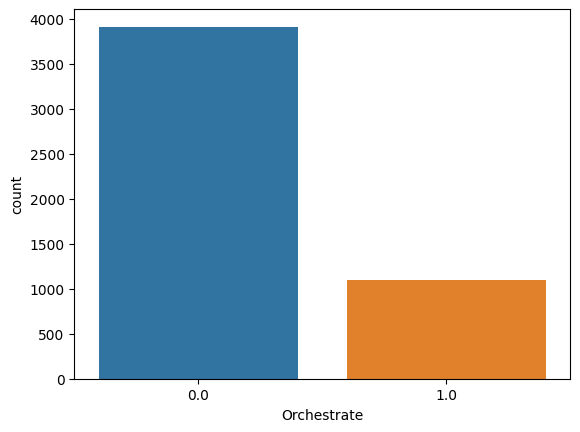

In [25]:
# Bar graph on the Input column from the dataset
import seaborn as sns
sns.countplot(x='Orchestrate', data=df_clean_af)

## Topic Modeling

In [26]:
# Topic Modelling using LDA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Creating a function to get the topics
def get_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return topics

# Creating a function to get the topic distribution
def get_topic_distribution(model, feature_names, n_top_words):
    topic_distribution = []
    for topic_idx, topic in enumerate(model.components_):
        topic_distribution.append([topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return topic_distribution

In [27]:
# converting tokenized into corpus and dictionary
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(df_clean_af['clean_tweets_raw'])
corpus = [dictionary.doc2bow(text) for text in df_clean_af['clean_tweets_raw']]
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(2, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


In [28]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[(0,
  '0.055*"ccp" + 0.019*

In [29]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.050380 -0.020080       1        1  17.278111
8     -0.055075  0.040636       2        1  14.292498
5     -0.048850 -0.017110       3        1  13.001087
6     -0.055087 -0.031326       4        1  12.170618
0     -0.042301  0.007032       5        1  10.342258
1      0.007151  0.000096       6        1   7.389523
4      0.045912  0.126866       7        1   7.012508
3      0.054946 -0.041682       8        1   6.533358
7      0.069777 -0.045872       9        1   6.139780
2      0.073909 -0.018561      10        1   5.840259, topic_info=           Term        Freq       Total Category  logprob  loglift
183    elonmusk  442.000000  442.000000  Default  30.0000  30.0000
55        china  659.000000  659.000000  Default  29.0000  29.0000
352        like  210.000000  210.000000  Default  28.0000  28.0000
345      people  462.000000  462.000000  Default  27.0000  27.0000
129     chinese  401.000000  401.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
231        doge    4.545915   26.997557  Topic10  -6.4405   1.0589
352        like    5.990694  210.579104  Topic10  -6.1645  -0.7193
1345  communist    5.291222   89.186358  Topic10  -6.2886   0.0157
102     support    5.296509  137.838054  Topic10  -6.2876  -0.4186
112       would    4.941463  119.308761  Topic10  -6.3570  -0.3437

[862 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
5043     10  0.644681  0xrainandcoffee
8028      1  0.871555           112822
3332      3  0.257958               12
3332      6  0.257958               12
3332     10  0.515917               12
...     ...       ...              ...
268       5  0.142384             足球预测
268       6  0.035596             足球预测
268       8  0.071192             足球预测
268       9  0.106788             足球预测
268      10  0.177980             足球预测

[2288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 6, 7, 1, 2, 5, 4, 8, 3])

In [30]:
#importing libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Splitting the dataset into train and test set
X = df_clean_af['clean_tweets_str']
y = df_clean_af['Orchestrate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# Vectorizing the tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Training the model using Logistic Regression
logreg = LogisticRegression()
logreg.fit(tfidf_train, y_train)

# Predicting the model
y_pred = logreg.predict(tfidf_test)
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
print('Classification report: ', classification_report(y_test, y_pred))

Accuracy score:  0.8515312916111851
Confusion matrix:  [[1139   37]
 [ 186  140]]
Classification report:                precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1176
         1.0       0.79      0.43      0.56       326

    accuracy                           0.85      1502
   macro avg       0.83      0.70      0.73      1502
weighted avg       0.84      0.85      0.83      1502

